# Lab 2: Iterative Algorithm Design

*By John Paul Bunn & Joseph Beattie*

## 1. Decision Rule

TODO: Insert this here

## 2. High-level Pseudocode

Note: This algorithm assumes that all points given to it are unique.




    list<pair<int, int>> convexHull(list<pair<int, int>> points) {
        
        // Find a centroid point amongst the given points
        centroid = getCentroid(points)

        // Define a reference point relative to the centroid
        ref = getReference(centroid)

        // For every point, process its interior angle. Additionally, process and find the lowest point.
        pairs = []
        lowestPoint = None
        lowestPair = None
        for point in points {
            if point != centroid {
                // First, define which region the point falls
                left = point.x <= centroid.x

                // 
                intAngle = getInteriorAngle(centroid, point, ref)
                if (!left) {
                    intAngle = 360 - intAngle
                }
                Pair<Point, Angle> pt_ang_pair = Pair(point, intAngle)
                pairs.append(pt_ang_pair)

                // Determine if the point is the lowest point
                if lowestPoint == None || point.y < lowestPoint.y || (point.y == lowestPoint.y && point.x < lowestPoint.x) {
                    lowestPoint = point
                    lowestPair = pt_ang_pair
                }
            }
        }

        // Sort the pairs
        sort(pairs)

        // Find the lowest point
        lowestPointIndex = 1
        while pairs[lowestPointIndex] != lowestPair {
            lowestPointIndex += 1
        }

        // Rotate the list to start at the lowest point
        pair_order = []
        for newIndex in range(1, len(pairs) + 1) {
            oldIndex = (newIndex + lowestPointIndex - 1) % len(pairs) + 1
            pair_order.append(pairs[oldIndex])
        }

        // For each pair, form a quadrilateral, and determine if the interior angle is convex

        // The currently-evaluated point will be part of return_points because it might not be
        //     the point immediately before the next point in pair_order
        // That said, i will still point one before the next point to make the loop logic easier
        //     (so we end at the last index)
        
        return_points = [pair_order[1], pair_order[2]]
        i = 2
        while i <= len(pair_order) {
            currPair = return_points.pop()
            prevPair = return_points[-1]
            
            if i == len(pair_order) {
                nextPair = pair_order[1]
            } else {
                nextPair = pair_order[i + 1]
            }
           
            intAngle = getInteriorAngleQuad(prevPair, currPair, nextPair, centroid)

            // Convex?
            if intAngle < 180 {
                // Add back the current point
                return_points.append(currPair)
                
                // Do the next point next
                return_points.append(nextPair)
                
                // Increment i to move forward
                i += 1
            } else if return_points.length == 2 {
                // Don't add back the current point (it's not in the hull)
                
                // Still do the next point next (since we can't step back)
                return_points.append(nextPair)
                
                // Increment i to move forward
                i += 1
            } else {
                // Don't add back the current point (it's not in the hull)
                
                // We're stepping back, so don't do the next point yet
                
                // Don't increment i, the following point hasn't changed
            }
        }

        // The first element of return_points was pushed in again, pop it off
        return_points.pop()
        
        // Extract the points from return_points
        convex_hull = []
        for pair in return_points:
            convex_hull.append(pair.point)

        return convex_hull
    }



## 3. Explanation / Justification

TODO: Insert this here

## 4. Worst-Case Run Time Analysis

TODO

## Implementation

Here is a Python implementation of our algorithm based on the pseudocode above. This implementation will be used for the remainder of this notebook.

In [43]:
import math

# Point class
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "Point(" + repr(self.x) + ", " + repr(self.y) + ")"
    def __eq__(self, other):
        return type(other) == type(self) \
            and self.x == other.x and self.y == other.y
    def __ne__(self, other):
        return not self == other
    def __hash__(self):
        return hash((self.x, self.y))

# Point-Angle-Pair class
class Pair:
    def __init__(self, point: Point, angle):
        self.point = point
        self.angle = angle
    def __repr__(self):
        return "Pair(" + repr(self.point) + ", " + repr(self.angle) + ")"
    def __eq__(self, other):
        return type(other) == type(self) \
            and self.point == other.point and self.angle == other.angle
    def __ne__(self, other):
        return not self == other

# Define some helper functions
def getCentroid(points: list) -> Point:
    avgX = 0
    avgY = 0
    for point in points:
        avgX += point.x
        avgY += point.y
    avgX /= len(points)
    avgY /= len(points)

    return Point(avgX, avgY)

def getReference(centroid: Point) -> Point:
    return Point(centroid.x, centroid.y - 10)

def getInteriorAngle(a: Point, b: Point, c: Point):
    side_a = math.sqrt((b.y - c.y) ** 2 + (b.x - c.x) ** 2)
    side_b = math.sqrt((a.y - c.y) ** 2 + (a.x - c.x) ** 2)
    side_c = math.sqrt((a.y - b.y) ** 2 + (a.x - b.x) ** 2)
    cosine = (side_a ** 2 + side_c ** 2 - side_b ** 2) / (2 * side_a * side_c)
    
    # Only allow 8 digits of precision
    # The cases where we need to be more precise than this are specialized and rare
    # This prevents the cosine being something like 1.0000000000000004
    #     due to floating-point error
    cosine = float("%.8f" % cosine)
    
    return math.degrees(math.acos(cosine))

def getInteriorAngleQuad(a: Point, b: Point, c: Point, d: Point):
    angleLeft = getInteriorAngle(a, b, d)
    angleRight = getInteriorAngle(d, b, c)
    return angleLeft + angleRight

def sortPointAnglePairs(pairs: list):
    pairs.sort(key=lambda p: p.angle)

def convexHullEdgePoints(points: list):
    # We can run the algorithm for down to 2 points, but not 1
    #   (since that would also be the centroid)
    if len(points) < 2:
        return points

    # Define a centroid
    centroid = getCentroid(points)

    # Define a reference point
    ref = getReference(centroid)

    pairs = []
    lowestPoint = None
    lowestPair = None
    for point in points:
        if point.x != centroid.x or point.y != centroid.y:
            # First, determine the left/right region of the centroid
            isLeft = point.x < centroid.x

            # Then find the interior angle
            intAngle = getInteriorAngle(point, centroid, ref)

            # Adjust for placement about the centroid
            if (not isLeft):
                intAngle = 360 - intAngle
            pt_ang_pair = Pair(point, intAngle)
            pairs.append(pt_ang_pair)

            # Determine if the point is the lowest point
            if lowestPoint == None or point.y < lowestPoint.y or (point.y == lowestPoint.y and point.x < lowestPoint.x):
                lowestPoint = point
                lowestPair = pt_ang_pair
            
    # Sort the pairs
    sortPointAnglePairs(pairs)

    # Find the lowest point
    lowestPointIndex = 0
    while pairs[lowestPointIndex] != lowestPair:
        lowestPointIndex += 1

    # Rotate the list to start at the lowest point
    pair_order = []
    for newIndex in range(0, len(pairs)):
        oldIndex = (newIndex + lowestPointIndex) % len(pairs)
        pair_order.append(pairs[oldIndex])

    # For each pair, form a quadrilateral, and determine if the interior angle is convex
    # The currently-evaluated point will be part of return_points because it might not be
    #     the point immediately before the next point in pair_order
    # That said, i will still point one before the next point to make the loop logic easier
    #     (so we end at the last index)
    return_points = [pair_order[0], pair_order[1]]
    i = 1
    while i < len(pair_order):
        currPair = return_points.pop()
        prevPair = return_points[-1]
        
        if i == len(pair_order) - 1:
            nextPair = pair_order[0]
        else:
            nextPair = pair_order[i + 1]
        
        intAngle = getInteriorAngleQuad(prevPair.point, currPair.point, nextPair.point, centroid)

        # Check: Convex?
        if intAngle < 180:
            # Add back the current point
            return_points.append(currPair)
            
            # Do the next point next
            return_points.append(nextPair)
            
            # Increment i to move forward
            i += 1
        elif len(return_points) == 1:
            # Don't add back the current point (it's not in the hull)
            return_points.append(nextPair)
            
            # Increment i to move forward
            i += 1

    # The first element of return_points was pushed in again, pop it off
    return_points.pop()
    
    # Extract the points from return_points
    convex_hull = []
    for pair in return_points:
        convex_hull.append(pair.point)

    return convex_hull


## 5. Test Cases

### Making sure the algorithm outputs correct results

Since we made the direction and starting point of the polygons our algorithm outputs fixed, there will be a single correct result for each set of inputs, which makes it relatively easy to test.

The test cases below are defined as a list of tuples, for which the first element is the input to the algorithm, the second element is the expected result, and the third element is a short description of the test case.

In [11]:
test_cases = [
    (
        [Point(0, 1), Point(-2, -1), Point(2, -1)],
        [Point(-2, -1), Point(0, 1), Point(2, -1)],
        "3-point simple test (for direction & starting point)"
    ),
    (
        [Point(0, 8), Point(-2, 7), Point(2, 7), Point(-3, 6), Point(3, 6),
         Point(-4, 4), Point(4, 4), Point(-3, 2), Point(3, 2), Point(-2, 1),
         Point(2, 1), Point(0, 0)],
        [Point(0, 0), Point(-2, 1), Point(-3, 2), Point(-4, 4), Point(-3, 6),
         Point(-2, 7), Point(0, 8), Point(2, 7), Point(3, 6), Point(4, 4),
         Point(3, 2), Point(2, 1)],
        "12-point test (for direction, starting point, & handling different sizes)"
    ),
    (
        [Point(0, 10), Point(-10, 0), Point(0, 0), Point(10, 0), Point(0, -10)],
        [Point(0, -10), Point(-10, 0), Point(0, 10), Point(10, 0)],
        "5-point test with centroid & reference points included in the given points"
    ),
    (
        [Point(0, 0), Point(0, 1), Point(0, 2), Point(0, 3)],
        [Point(0, 0), Point(0, 3)],
        "4-point test with all points in a line"
    ),
    (
        [Point(-1, -1), Point(0, 0), Point(1, 1)],
        [Point(-1, -1), Point(1, 1)],
        "3-point test with centroid included (which should be removed)"
    ),
    (
        [Point(3, 3)],
        [Point(3, 3)],
        "1-point test"
    ),
    (
        [Point(0, 8), Point(8, 8), Point(2, 5), Point(6, 5), Point(1, 4), Point(4, 4),
         Point(7, 4), Point(2, 3), Point(6, 3), Point(0, 0), Point(8, 0)],
        [Point(0, 0), Point(0, 8), Point(8, 8), Point(8, 0)],
        "11-point test for both forms of stepping back as well as centroid comparison"
    ),
    (
        [Point(1, 4), Point(2, 4), Point(3, 4), Point(0.5, 3), Point(3.5, 3),
         Point(0, 2), Point(4, 2), Point(0, 0), Point(2, 0), Point(4, 0)],
        [Point(0, 0), Point(0, 2), Point(1, 4), Point(3, 4), Point(4, 2), Point(4, 0)],
        "10-point test for removal of points with 180-degree interior angles"
    ),
    (
        [Point(-4, 2), Point(0, 1), Point(2, 1), Point(-2, -1), Point(0, -1),
         Point(4, -2)],
        [Point(4, -2), Point(-2, -1), Point(-4, 2), Point(2, 1)],
        "6-point test for a case where the starting point is the rightmost point"
    ),
]

Now to actually test our algorithm. If the algorithm is broken for any of the listed cases, all_passed will be set to False and the expected and actual outputs for the test cases will be displayed.

In [12]:
all_passed = True
for orig_points, expected, name in test_cases:
    convex_hull = convexHullEdgePoints(orig_points)
    all_passed &= convex_hull == expected
    if convex_hull != expected:
        print("Case failed!")
        print(name)
        print("Expected:", expected)
        print("Actual:", convex_hull)
        print()
print("all_passed =", all_passed)

all_passed = True


Since all_passed is now True, the outputs of our algorithm match all of the expected outputs for each test case.

### Visualizing the test cases

To visualize the test cases, we will define a method that uses Matplotlib to plot a given test case:

In [13]:
import matplotlib.pyplot as plt

In [14]:
def plot_test_case(test_case, ax):
    input_x = [pt.x for pt in test_case[0]]
    input_y = [pt.y for pt in test_case[0]]
    
    output_x = [pt.x for pt in test_case[1]]
    output_y = [pt.y for pt in test_case[1]]
    
    # Re-add the first point to the output arrays to complete the polygon when drawing
    output_x.append(test_case[1][0].x)
    output_y.append(test_case[1][0].y)
    
    # Make all points red by default (they will stay red if eliminated)
    ax.scatter(input_x, input_y, color='red')
    
    # Trace the convex hull using purple lines
    ax.plot(output_x, output_y, color='purple')
    
    # Make kept points green
    ax.scatter(output_x, output_y, color='green')
    
    # Make starting point blue
    ax.scatter(output_x[0], output_y[0], color='blue')
    
    # Title & axis labels
    ax.set_title(test_case[2])
    ax.set_xlabel("x")
    ax.set_ylabel("y")

Now, we can trivially plot each test case. In each of the below plots:

- The input is a list of all of the points of any color
- The convex hull is outlined by a purple line
- The expected output (and actual, since we found above that they match) is a list starting with the blue point and including all of the green points in clockwise order following the purple line

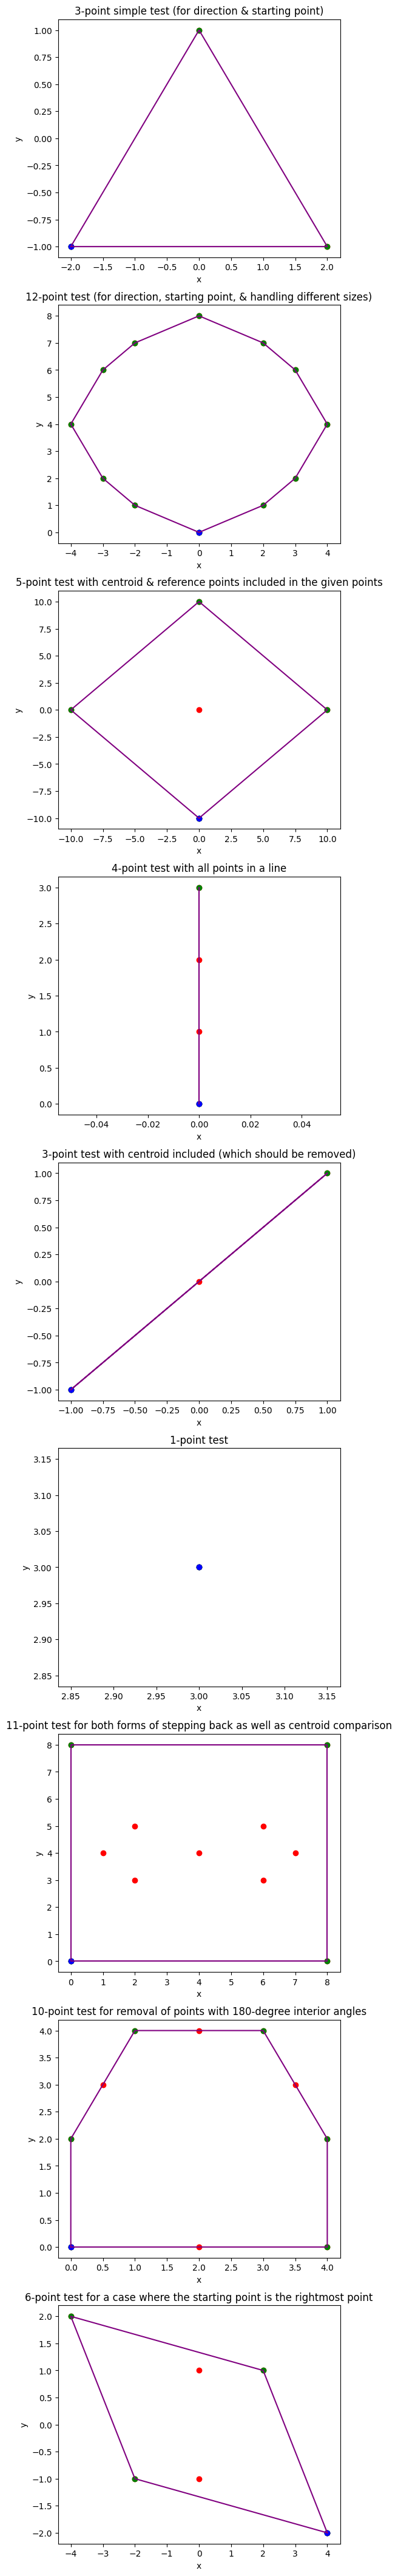

In [15]:
num_cases = len(test_cases)
fig, ax = plt.subplots(num_cases, figsize=(6, 6 * num_cases))
for case_num in range(num_cases):
    plot_test_case(test_cases[case_num], ax[case_num])
plt.show()

## 6. Benchmarking

TODO

In [58]:
import random
def default_point_maker(x, y):
    return (x, y)

def circle_point_maker(x, y):
    
    
    return (math.sin(x), math.cos(x))

def generate_points(n, a, b, pointmaker=default_point_maker):
    ret_set = set()
    while len(ret_set) < n:
        pt = pointmaker(random.random()*(b-a) + a, random.random()*(b-a) + a)
        ret_set.add(Point(pt[0], pt[1]))
    return list(ret_set)

In [32]:
import time
def benchmark(input_list, algorithm=convexHullEdgePoints, do_print=False):
    start_time = time.perf_counter()

    algorithm(input_list)

    end_time = time.perf_counter()
    elapsed = end_time - start_time

    if do_print:
        print("Benchmark time elapsed:", elapsed)
    return elapsed

for input_list, _, _ in test_cases: 
    # Make sure all of our test cases can be successfully benchmarked
    elapsed = benchmark(input_list)

## Average case

Unique points randomly generated and benchmarked.

In [34]:
avg_times = []
ns = range(100, int(10e3), 100)
a = -100
b = 100
num_cases = 10

for n in ns:
    cases = [generate_points(n,a,b) for _ in range(num_cases)]
    elapsed_times = [benchmark(case, do_print=True) for case in cases]
    elapsed_avg_time = sum(elapsed_times) / len(elapsed_times)
    avg_times.append(elapsed_avg_time)

plt.scatter(n, avg_times, color='red')
# Title & axis labels
plt.title("Benchmark Plots")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Benchmark time elapsed: 4.1000021155923605e-06
Benchmark time elapsed: 7.999769877642393e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 1.00000761449337e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchma

KeyboardInterrupt: 

## Worst Case

Our worst case would be if all points were laid out on a perfect circle. This would mean that all points are on the convex hull.

N is 1
Benchmark time elapsed: 4.0000013541430235e-06
Benchmark time elapsed: 5.00003807246685e-07
Benchmark time elapsed: 3.00002284348011e-07
Benchmark time elapsed: 3.00002284348011e-07
Benchmark time elapsed: 2.999731805175543e-07
Benchmark time elapsed: 3.00002284348011e-07
Benchmark time elapsed: 3.00002284348011e-07
Benchmark time elapsed: 2.00001522898674e-07
Benchmark time elapsed: 4.00003045797348e-07
Benchmark time elapsed: 2.00001522898674e-07
N is 101
Benchmark time elapsed: 0.0016146999842021614
Benchmark time elapsed: 0.0014500999823212624
Benchmark time elapsed: 0.0014364000235218555
Benchmark time elapsed: 0.0012879999994765967
Benchmark time elapsed: 0.0009137999732047319
Benchmark time elapsed: 0.000817699998151511
Benchmark time elapsed: 0.0010150999878533185
Benchmark time elapsed: 0.0011003999970853329
Benchmark time elapsed: 0.0008623999892733991
Benchmark time elapsed: 0.0007841000042390078
N is 201
Benchmark time elapsed: 0.0029568999889306724
Benchmark time el

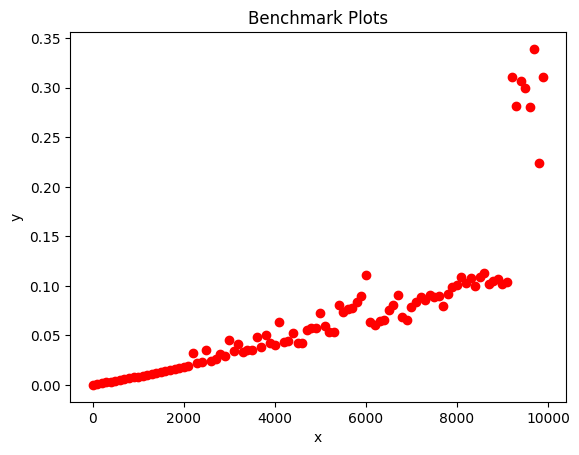

In [64]:
avg_times = []
ns = list(range(1, int(1e4), 100))
a = -100
b = 100
num_cases = 10

for n in ns:
    print("N is", n)
    cases = [generate_points(n,a,b,pointmaker=circle_point_maker) for _ in range(num_cases)]
    elapsed_times = [benchmark(case, do_print=True) for case in cases]
    elapsed_avg_time = sum(elapsed_times) / len(elapsed_times)
    avg_times.append(elapsed_avg_time)

plt.scatter(ns, avg_times, color='red')
# Title & axis labels
plt.title("Benchmark Plots")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

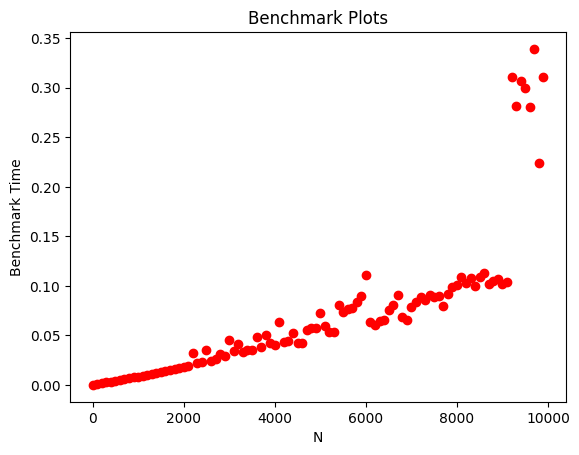

In [65]:
plt.scatter(ns, avg_times, color='red')
# Title & axis labels
plt.title("Benchmark Plots")
plt.xlabel("N")
plt.ylabel("Benchmark Time")
plt.show()

In [75]:
import pandas as pd
df = pd.DataFrame({'array1': ns, 'array2': avg_times})
print(df.to_string())

    array1        array2
0        1  6.799994e-07
1      101  1.128270e-03
2      201  2.243950e-03
3      301  2.562640e-03
4      401  3.289730e-03
5      501  4.049730e-03
6      601  4.854460e-03
7      701  6.095690e-03
8      801  7.321690e-03
9      901  7.906340e-03
10    1001  8.243200e-03
11    1101  9.434460e-03
12    1201  9.837780e-03
13    1301  1.151626e-02
14    1401  1.219472e-02
15    1501  1.274659e-02
16    1601  1.425541e-02
17    1701  1.494817e-02
18    1801  1.598233e-02
19    1901  1.747876e-02
20    2001  1.793890e-02
21    2101  1.911893e-02
22    2201  3.266089e-02
23    2301  2.261723e-02
24    2401  2.318398e-02
25    2501  3.575272e-02
26    2601  2.450578e-02
27    2701  2.656635e-02
28    2801  3.092911e-02
29    2901  2.922739e-02
30    3001  4.516036e-02
31    3101  3.386849e-02
32    3201  4.165486e-02
33    3301  3.274511e-02
34    3401  3.483605e-02
35    3501  3.544635e-02
36    3601  4.864922e-02
37    3701  3.811257e-02
38    3801  5.051262e-02


## 7. Appendix

TODO